# 07 — Single-Task Baseline (IndoBERT + CRF)

Notebook ini melatih model **single-task** untuk ABSA sebagai **baseline pembanding** terhadap model multi-task (Wang et al., 2021).

**Perbedaan utama:**
| Aspek | Multi-Task (NB 03) | Single-Task (NB 07) |
|---|---|---|
| Arsitektur | IndoBERT → ATE + SLD + ASD + CRF | IndoBERT → CRF langsung |
| Intermediate tasks | ATE, SLD, ASD (4 sub-tasks) | Tidak ada |
| Prior Embedding | Ya (word-level ATE frequency) | Tidak |
| Cross-Attention | Ya (ATE → SLD, Paper Eq. 7-9) | Tidak |
| Sentiment Connection | Ya (SLD → ASD) | Tidak |
| Loss | λ1(L_ae+L_sl) + λ2*L_sd + L_crf | L_crf saja |
| Training phases | Phase 1 (SLD) + Phase 2 | Single phase |

**Hyperparameters identik dengan NB 03** untuk fair comparison:
- Dropout: 0.1, Weight Decay: 0.01, No freeze, LR BERT: 2e-5, LR Head: 1e-4
- Batch: 4 × 4 accum = 16 effective, Epochs: 18, Split: 85/15 seed=42

In [1]:
import json
import os
import string
import time
from collections import Counter

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoModel, AutoTokenizer, get_linear_schedule_with_warmup
from torchcrf import CRF
from seqeval.metrics import classification_report, f1_score as seq_f1_score
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set_theme(style='whitegrid')
plt.rcParams['figure.dpi'] = 120

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'PyTorch: {torch.__version__}')
print(f'Device: {device}')
if torch.cuda.is_available():
    print(f'GPU: {torch.cuda.get_device_name(0)}')
    print(f'VRAM: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB')

PyTorch: 2.5.1+cu121
Device: cuda
GPU: NVIDIA GeForce RTX 4060 Laptop GPU
VRAM: 8.0 GB


### 1. KONFIGURASI

In [2]:
# Paths
BASE_DIR = os.path.dirname(os.getcwd())
DATA_PROC_DIR = os.path.join(BASE_DIR, 'data', 'processed')
MODEL_DIR = os.path.join(BASE_DIR, 'models')
os.makedirs(MODEL_DIR, exist_ok=True)

BIEOS_PATH = os.path.join(DATA_PROC_DIR, 'train_data_bieos.json')

# Model
MODEL_NAME = 'indobenchmark/indobert-large-p2'
MAX_LENGTH = 128
PROJ_DIM = 256

# Training — identik dengan NB 03
BATCH_SIZE = 4
GRADIENT_ACCUMULATION = 4  # effective batch = 16
NUM_EPOCHS = 18
LR_BERT = 2e-5
LR_HEAD = 1e-4
WARMUP_RATIO = 0.1
WEIGHT_DECAY = 0.01
MAX_GRAD_NORM = 1.0
TRAIN_RATIO = 0.85
SEED = 42

# Architecture
DROPOUT = 0.1
PATIENCE = 5  # early stopping

torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

print(f'Model       : {MODEL_NAME}')
print(f'Batch size  : {BATCH_SIZE} x {GRADIENT_ACCUMULATION} accum = {BATCH_SIZE * GRADIENT_ACCUMULATION} effective')
print(f'Epochs      : {NUM_EPOCHS} (early stopping patience={PATIENCE})')
print(f'LR (BERT)   : {LR_BERT}')
print(f'LR (heads)  : {LR_HEAD}')
print(f'Loss        : CRF NLL only (no multi-task losses)')

Model       : indobenchmark/indobert-large-p2
Batch size  : 4 x 4 accum = 16 effective
Epochs      : 18 (early stopping patience=5)
LR (BERT)   : 2e-05
LR (heads)  : 0.0001
Loss        : CRF NLL only (no multi-task losses)


### 2. LOAD DATA

In [3]:
with open(BIEOS_PATH, 'r', encoding='utf-8') as f:
    raw_data = json.load(f)
print(f'Total data: {len(raw_data)}')

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
print(f'Tokenizer loaded: {MODEL_NAME}')

Total data: 2451
Tokenizer loaded: indobenchmark/indobert-large-p2


### 3. LABEL SCHEME

Single-task hanya butuh **BIEOS labels** (13 kelas) — tidak ada ATE, SLD, ASD.

In [4]:
bieos_labels = ['O', 'B-NEG', 'B-NEU', 'B-POS', 'E-NEG', 'E-NEU', 'E-POS',
                'I-NEG', 'I-NEU', 'I-POS', 'S-NEG', 'S-NEU', 'S-POS']

bieos_label2id = {l: i for i, l in enumerate(bieos_labels)}
bieos_id2label = {i: l for l, i in bieos_label2id.items()}

IGNORE_INDEX = -100

print(f'BIEOS labels ({len(bieos_labels)}):')
for i, l in enumerate(bieos_labels):
    print(f'  {i:2d}: {l}')

BIEOS labels (13):
   0: O
   1: B-NEG
   2: B-NEU
   3: B-POS
   4: E-NEG
   5: E-NEU
   6: E-POS
   7: I-NEG
   8: I-NEU
   9: I-POS
  10: S-NEG
  11: S-NEU
  12: S-POS


### 4. DATA PREPARATION

Simplified — hanya tokenisasi + BIEOS label alignment. Tidak perlu ATE/SLD/ASD labels atau prior embedding.

In [5]:
all_input_ids = []
all_attention_mask = []
all_bieos = []
all_crf = []

for d in tqdm(raw_data, desc='Preparing labels'):
    tokens, labels = d['tokens'], d['labels']

    enc = tokenizer(tokens, is_split_into_words=True,
                    max_length=MAX_LENGTH, padding='max_length',
                    truncation=True, return_tensors='pt')
    word_ids = enc.word_ids(batch_index=0)

    bieos_a, crf_a = [], []
    prev_wid = None
    for wid in word_ids:
        if wid is None:
            bieos_a.append(IGNORE_INDEX)
            crf_a.append(0)
        elif wid != prev_wid:
            if wid < len(tokens):
                bieos_a.append(bieos_label2id[labels[wid]])
                crf_a.append(bieos_label2id[labels[wid]])
            else:
                bieos_a.append(IGNORE_INDEX)
                crf_a.append(0)
        else:
            bieos_a.append(IGNORE_INDEX)
            crf_a.append(bieos_label2id[labels[wid]] if wid < len(tokens) else 0)
        prev_wid = wid

    all_input_ids.append(enc['input_ids'].squeeze(0))
    all_attention_mask.append(enc['attention_mask'].squeeze(0))
    all_bieos.append(torch.tensor(bieos_a, dtype=torch.long))
    all_crf.append(torch.tensor(crf_a, dtype=torch.long))

data_dict = {
    'input_ids': torch.stack(all_input_ids),
    'attention_mask': torch.stack(all_attention_mask),
    'bieos_labels': torch.stack(all_bieos),
    'crf_labels': torch.stack(all_crf),
}

print('\nDataset shapes:')
for k, v in data_dict.items():
    print(f'  {k}: {v.shape}')

Preparing labels:   0%|          | 0/2451 [00:00<?, ?it/s]


Dataset shapes:
  input_ids: torch.Size([2451, 128])
  attention_mask: torch.Size([2451, 128])
  bieos_labels: torch.Size([2451, 128])
  crf_labels: torch.Size([2451, 128])


### 5. DATASET & SPLIT

In [6]:
class ABSADataset(Dataset):
    def __init__(self, data_dict, indices):
        self.data = {k: v[indices] for k, v in data_dict.items()}

    def __len__(self):
        return self.data['input_ids'].size(0)

    def __getitem__(self, idx):
        return {k: v[idx] for k, v in self.data.items()}

# Train/Val split — identik dengan NB 03
total = len(raw_data)
indices = torch.randperm(total, generator=torch.Generator().manual_seed(SEED))
split = int(total * TRAIN_RATIO)

train_dataset = ABSADataset(data_dict, indices[:split])
val_dataset = ABSADataset(data_dict, indices[split:])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE * 2)

print(f'Train: {len(train_dataset)} ({TRAIN_RATIO*100:.0f}%)')
print(f'Val  : {len(val_dataset)} ({(1-TRAIN_RATIO)*100:.0f}%)')
print(f'Train batches: {len(train_loader)}')

Train: 2083 (85%)
Val  : 368 (15%)
Train batches: 521


### 6. MODEL: SingleTaskABSA

```
IndoBERT (shared encoder)
        |
        h (1024-dim)
        |
     Dropout
        |
   Linear(1024→256) + GELU + Dropout
        |
   Linear(256→13)  ← emissions
        |
      CRF (13 labels)
```

Tanpa intermediate tasks (ATE, SLD, ASD), prior embedding, dan cross-attention.

In [7]:
class SingleTaskABSA(nn.Module):
    def __init__(self, model_name, num_labels, proj_dim=256, dropout=0.1):
        super().__init__()
        self.bert = AutoModel.from_pretrained(model_name, use_safetensors=True, low_cpu_mem_usage=True)
        bert_dim = self.bert.config.hidden_size  # 1024

        self.proj = nn.Sequential(
            nn.Linear(bert_dim, proj_dim),
            nn.GELU(),
            nn.Dropout(dropout),
        )
        self.emission = nn.Linear(proj_dim, num_labels)
        self.crf = CRF(num_labels, batch_first=True)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input_ids, attention_mask,
                crf_labels=None, bieos_labels=None, **kwargs):
        h = self.dropout(
            self.bert(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state
        )
        emissions = self.emission(self.proj(h))

        outputs = {'emissions': emissions}

        if crf_labels is not None:
            mask = attention_mask.bool()
            loss = -self.crf(emissions.float(), crf_labels, mask=mask, reduction='mean')
            outputs['loss'] = loss

        return outputs

    def decode(self, emissions, attention_mask):
        return self.crf.decode(emissions.float(), mask=attention_mask.bool())

### 7. TRAINING SETUP

In [8]:
model = SingleTaskABSA(
    model_name=MODEL_NAME,
    num_labels=len(bieos_labels),
    proj_dim=PROJ_DIM,
    dropout=DROPOUT,
).to(device)

total_params = sum(p.numel() for p in model.parameters())
trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Total parameters    : {total_params:,}')
print(f'Trainable parameters: {trainable:,}')
print(f'BERT hidden size    : {model.bert.config.hidden_size}')

# Optimizer: different LR for BERT vs task head
bert_params = list(model.bert.named_parameters())
head_params = [(n, p) for n, p in model.named_parameters() if not n.startswith('bert')]

total_steps = (len(train_loader) // GRADIENT_ACCUMULATION) * NUM_EPOCHS
warmup_steps = int(total_steps * WARMUP_RATIO)

optimizer = torch.optim.AdamW([
    {'params': [p for _, p in bert_params], 'lr': LR_BERT},
    {'params': [p for _, p in head_params], 'lr': LR_HEAD},
], weight_decay=WEIGHT_DECAY)

scheduler = get_linear_schedule_with_warmup(optimizer, warmup_steps, total_steps)

print(f'\nTotal steps   : {total_steps}')
print(f'Warmup steps  : {warmup_steps}')

Loading weights:   0%|          | 0/391 [00:00<?, ?it/s]

Total parameters    : 335,407,824
Trainable parameters: 335,407,824
BERT hidden size    : 1024

Total steps   : 2340
Warmup steps  : 234


### 8. TRAINING

In [9]:
def evaluate(model, dataloader, device, desc='Evaluating'):
    """Evaluate model: compute loss + entity-level F1 from CRF predictions."""
    model.eval()
    total_loss = 0
    all_preds, all_true = [], []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc=desc, leave=False):
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            total_loss += outputs['loss'].item()

            preds = model.decode(outputs['emissions'], batch['attention_mask'])
            bieos_lbl = batch['bieos_labels']

            for i in range(len(preds)):
                pred_seq, true_seq = [], []
                for j in range(len(preds[i])):
                    if bieos_lbl[i][j].item() != IGNORE_INDEX:
                        pred_seq.append(bieos_id2label[preds[i][j]])
                        true_seq.append(bieos_id2label[bieos_lbl[i][j].item()])
                all_preds.append(pred_seq)
                all_true.append(true_seq)

    avg_loss = total_loss / len(dataloader)
    f1 = seq_f1_score(all_true, all_preds)
    return avg_loss, f1, all_true, all_preds


# Training history
history = {'train_loss': [], 'val_loss': [], 'val_f1': []}

best_f1 = 0
patience_counter = 0
best_epoch = 0

print('=' * 60)
print(f'TRAINING: Single-Task ABSA ({NUM_EPOCHS} epochs, patience={PATIENCE})')
print('=' * 60)

for epoch in range(NUM_EPOCHS):
    model.train()
    epoch_loss = 0
    optimizer.zero_grad()
    t0 = time.time()

    step_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{NUM_EPOCHS}', leave=False, unit='batch')
    for step, batch in enumerate(step_bar):
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs['loss'] / GRADIENT_ACCUMULATION
        loss.backward()

        if (step + 1) % GRADIENT_ACCUMULATION == 0 or (step + 1) == len(train_loader):
            torch.nn.utils.clip_grad_norm_(model.parameters(), MAX_GRAD_NORM)
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()

        epoch_loss += outputs['loss'].item()
        step_bar.set_postfix(loss=f"{epoch_loss/(step+1):.3f}")

    avg_train = epoch_loss / len(train_loader)
    elapsed = time.time() - t0

    # Validation
    val_loss, val_f1, _, _ = evaluate(model, val_loader, device, desc='Validating')

    history['train_loss'].append(avg_train)
    history['val_loss'].append(val_loss)
    history['val_f1'].append(val_f1)

    improved = val_f1 > best_f1
    if improved:
        best_f1 = val_f1
        best_epoch = epoch + 1
        patience_counter = 0
        torch.save(model.state_dict(), os.path.join(MODEL_DIR, 'best_model_singletask.pt'))
    else:
        patience_counter += 1

    tqdm.write(
        f'Epoch {epoch+1:2d}/{NUM_EPOCHS} | {elapsed:.0f}s | '
        f'Train: {avg_train:.4f} | Val: {val_loss:.4f} | '
        f'F1: {val_f1:.4f} {"*" if improved else ""}')

    if patience_counter >= PATIENCE:
        tqdm.write(f'\nEarly stopping at epoch {epoch+1} (no improvement for {PATIENCE} epochs)')
        break

actual_epochs = len(history['train_loss'])
print(f'\nTraining finished after {actual_epochs} epochs')
print(f'Best Val F1: {best_f1:.4f} (epoch {best_epoch})')

TRAINING: Single-Task ABSA (18 epochs, patience=5)


Epoch 1/18:   0%|          | 0/521 [00:00<?, ?batch/s]

Validating:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch  1/18 | 274s | Train: 31.7037 | Val: 12.2133 | F1: 0.3863 *


Epoch 2/18:   0%|          | 0/521 [00:00<?, ?batch/s]

Validating:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch  2/18 | 270s | Train: 10.2557 | Val: 7.1936 | F1: 0.6171 *


Epoch 3/18:   0%|          | 0/521 [00:00<?, ?batch/s]

Validating:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch  3/18 | 260s | Train: 5.6686 | Val: 6.0518 | F1: 0.6821 *


Epoch 4/18:   0%|          | 0/521 [00:00<?, ?batch/s]

Validating:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch  4/18 | 249s | Train: 3.3075 | Val: 6.2236 | F1: 0.7102 *


Epoch 5/18:   0%|          | 0/521 [00:00<?, ?batch/s]

Validating:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch  5/18 | 254s | Train: 1.9986 | Val: 6.8699 | F1: 0.7232 *


Epoch 6/18:   0%|          | 0/521 [00:00<?, ?batch/s]

Validating:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch  6/18 | 246s | Train: 1.2891 | Val: 8.3265 | F1: 0.7332 *


Epoch 7/18:   0%|          | 0/521 [00:00<?, ?batch/s]

Validating:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch  7/18 | 253s | Train: 0.7725 | Val: 9.2004 | F1: 0.7250 


Epoch 8/18:   0%|          | 0/521 [00:00<?, ?batch/s]

Validating:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch  8/18 | 252s | Train: 0.5050 | Val: 10.0589 | F1: 0.7217 


Epoch 9/18:   0%|          | 0/521 [00:00<?, ?batch/s]

Validating:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch  9/18 | 249s | Train: 0.3899 | Val: 10.0672 | F1: 0.7526 *


Epoch 10/18:   0%|          | 0/521 [00:00<?, ?batch/s]

Validating:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 10/18 | 254s | Train: 0.2562 | Val: 12.2444 | F1: 0.7358 


Epoch 11/18:   0%|          | 0/521 [00:00<?, ?batch/s]

Validating:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 11/18 | 246s | Train: 0.2160 | Val: 12.2429 | F1: 0.7551 *


Epoch 12/18:   0%|          | 0/521 [00:00<?, ?batch/s]

Validating:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 12/18 | 252s | Train: 0.1306 | Val: 13.3642 | F1: 0.7418 


Epoch 13/18:   0%|          | 0/521 [00:00<?, ?batch/s]

KeyboardInterrupt: 

### 9. VISUALISASI TRAINING

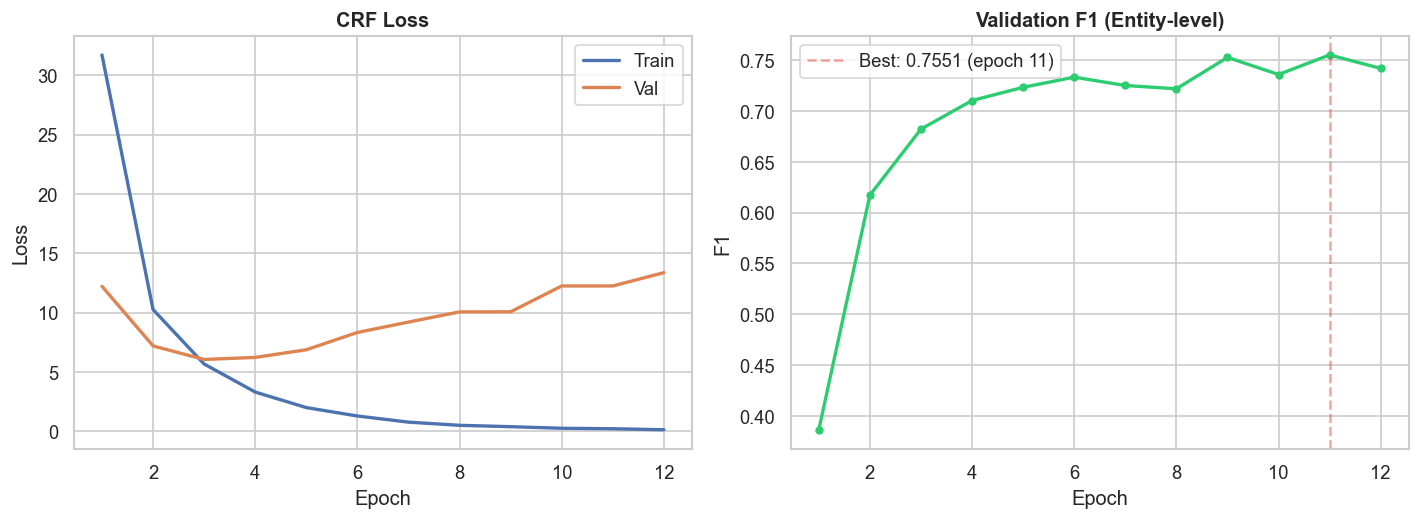

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4.5))

epochs_range = range(1, len(history['train_loss']) + 1)

# Loss curves
axes[0].plot(epochs_range, history['train_loss'], label='Train', linewidth=2)
axes[0].plot(epochs_range, history['val_loss'], label='Val', linewidth=2)
axes[0].set_title('CRF Loss', fontweight='bold')
axes[0].set_xlabel('Epoch'); axes[0].set_ylabel('Loss')
axes[0].legend()

# F1 curve
axes[1].plot(epochs_range, history['val_f1'], color='#2ecc71', linewidth=2, marker='o', markersize=4)
axes[1].axvline(best_epoch, color='#e74c3c', linestyle='--', alpha=0.5,
                label=f'Best: {best_f1:.4f} (epoch {best_epoch})')
axes[1].set_title('Validation F1 (Entity-level)', fontweight='bold')
axes[1].set_xlabel('Epoch'); axes[1].set_ylabel('F1')
axes[1].legend()

plt.tight_layout()
plt.show()

### 10. EVALUASI FINAL

In [11]:
# Load best model
model.load_state_dict(torch.load(os.path.join(MODEL_DIR, 'best_model_singletask.pt'), weights_only=True))
val_loss, val_f1, all_true, all_preds = evaluate(model, val_loader, device)

print(f'Best Model - Val Loss: {val_loss:.4f}, Val F1: {val_f1:.4f}')
print(f'\n{classification_report(all_true, all_preds)}')

Evaluating:   0%|          | 0/46 [00:00<?, ?it/s]

Best Model - Val Loss: 12.2429, Val F1: 0.7551

              precision    recall  f1-score   support

         NEG       0.65      0.61      0.63        83
         NEU       0.54      0.66      0.59       125
         POS       0.80      0.83      0.82       536

   micro avg       0.73      0.78      0.76       744
   macro avg       0.66      0.70      0.68       744
weighted avg       0.74      0.78      0.76       744



### 11. ERROR PROPAGATION ANALYSIS

Analisis tipe error untuk membandingkan single-task vs multi-task:
1. **Boundary error**: prefix (B/I/E/S/O) salah → aspect boundary detection gagal
2. **Sentiment error**: prefix benar tapi sentiment (POS/NEG/NEU) salah → sentiment classification gagal
3. **Both**: boundary dan sentiment keduanya salah

In [12]:
def analyze_errors(all_true, all_preds):
    """Decompose errors into boundary vs sentiment errors."""
    boundary_errors = 0
    sentiment_errors = 0
    both_errors = 0
    correct = 0
    total_tokens = 0

    for true_seq, pred_seq in zip(all_true, all_preds):
        for t, p in zip(true_seq, pred_seq):
            total_tokens += 1
            if t == p:
                correct += 1
                continue

            # Parse prefix and sentiment
            t_prefix = t.split('-')[0] if '-' in t else t
            t_sent = t.split('-')[1] if '-' in t else None
            p_prefix = p.split('-')[0] if '-' in p else p
            p_sent = p.split('-')[1] if '-' in p else None

            boundary_wrong = (t_prefix != p_prefix)
            sentiment_wrong = (t_sent != p_sent)

            if boundary_wrong and sentiment_wrong:
                both_errors += 1
            elif boundary_wrong:
                boundary_errors += 1
            elif sentiment_wrong:
                sentiment_errors += 1

    total_errors = boundary_errors + sentiment_errors + both_errors
    return {
        'total_tokens': total_tokens,
        'correct': correct,
        'total_errors': total_errors,
        'boundary_only': boundary_errors,
        'sentiment_only': sentiment_errors,
        'both': both_errors,
    }


def sentiment_confusion(all_true, all_preds):
    """Build confusion matrix for sentiment labels (only on aspect tokens)."""
    sentiments = ['POS', 'NEG', 'NEU']
    matrix = {t: {p: 0 for p in sentiments + ['O/miss']} for t in sentiments}

    for true_seq, pred_seq in zip(all_true, all_preds):
        for t, p in zip(true_seq, pred_seq):
            if t == 'O':
                continue
            t_sent = t.split('-')[1] if '-' in t else None
            if t_sent not in sentiments:
                continue
            if p == 'O' or '-' not in p:
                matrix[t_sent]['O/miss'] += 1
            else:
                p_sent = p.split('-')[1]
                if p_sent in sentiments:
                    matrix[t_sent][p_sent] += 1
                else:
                    matrix[t_sent]['O/miss'] += 1

    return matrix


# --- Single-task error analysis ---
st_errors = analyze_errors(all_true, all_preds)
st_confusion = sentiment_confusion(all_true, all_preds)

print('=== Single-Task Error Decomposition ===')
print(f'Total tokens : {st_errors["total_tokens"]}')
print(f'Correct      : {st_errors["correct"]} ({st_errors["correct"]/st_errors["total_tokens"]*100:.1f}%)')
print(f'Total errors : {st_errors["total_errors"]}')
print(f'  Boundary only  : {st_errors["boundary_only"]:4d} ({st_errors["boundary_only"]/max(st_errors["total_errors"],1)*100:.1f}%)')
print(f'  Sentiment only : {st_errors["sentiment_only"]:4d} ({st_errors["sentiment_only"]/max(st_errors["total_errors"],1)*100:.1f}%)')
print(f'  Both           : {st_errors["both"]:4d} ({st_errors["both"]/max(st_errors["total_errors"],1)*100:.1f}%)')

print('\n=== Sentiment Confusion Matrix (aspect tokens only) ===')
sentiments = ['POS', 'NEG', 'NEU']
header = f'{"True/Pred":>10s}' + ''.join(f'{s:>8s}' for s in sentiments + ['O/miss'])
print(header)
for t_sent in sentiments:
    row = f'{t_sent:>10s}'
    for p_sent in sentiments + ['O/miss']:
        row += f'{st_confusion[t_sent][p_sent]:>8d}'
    print(row)

=== Single-Task Error Decomposition ===
Total tokens : 7759
Correct      : 7233 (93.2%)
Total errors : 526
  Boundary only  :   44 (8.4%)
  Sentiment only :   57 (10.8%)
  Both           :  425 (80.8%)

=== Sentiment Confusion Matrix (aspect tokens only) ===
 True/Pred     POS     NEG     NEU  O/miss
       POS     702       0      31     107
       NEG       3     111       2      42
       NEU      20       3     177      40


### 12. PERBANDINGAN DENGAN MULTI-TASK

In [13]:
# Load multi-task checkpoint (NB 03) untuk perbandingan
mt_checkpoint_path = os.path.join(MODEL_DIR, 'checkpoint_final.pt')

if os.path.exists(mt_checkpoint_path):
    mt_ckpt = torch.load(mt_checkpoint_path, weights_only=False, map_location='cpu')
    mt_f1 = mt_ckpt.get('best_f1', None)

    # Cek apakah ada val_true/val_preds dari multi-task
    mt_true = mt_ckpt.get('val_true', None)
    mt_preds = mt_ckpt.get('val_preds', None)

    print('=== PERBANDINGAN: Multi-Task vs Single-Task ===')
    print(f'Multi-task F1  (NB 03): {mt_f1:.4f}' if mt_f1 else 'Multi-task F1: not found')
    print(f'Single-task F1 (NB 07): {best_f1:.4f}')
    if mt_f1:
        diff = best_f1 - mt_f1
        print(f'Difference             : {diff:+.4f} ({"single-task lebih baik" if diff > 0 else "multi-task lebih baik"})')

    # Error decomposition comparison
    if mt_true is not None and mt_preds is not None:
        mt_errors = analyze_errors(mt_true, mt_preds)
        mt_confusion = sentiment_confusion(mt_true, mt_preds)

        print('\n=== Error Decomposition Comparison ===')
        print(f'{"":>20s} {"Multi-Task":>12s} {"Single-Task":>12s}')
        print(f'{"Total errors":>20s} {mt_errors["total_errors"]:>12d} {st_errors["total_errors"]:>12d}')
        print(f'{"Boundary only":>20s} {mt_errors["boundary_only"]:>12d} {st_errors["boundary_only"]:>12d}')
        print(f'{"Sentiment only":>20s} {mt_errors["sentiment_only"]:>12d} {st_errors["sentiment_only"]:>12d}')
        print(f'{"Both":>20s} {mt_errors["both"]:>12d} {st_errors["both"]:>12d}')

        print('\n=== Multi-Task Sentiment Confusion ===')
        header = f'{"True/Pred":>10s}' + ''.join(f'{s:>8s}' for s in sentiments + ['O/miss'])
        print(header)
        for t_sent in sentiments:
            row = f'{t_sent:>10s}'
            for p_sent in sentiments + ['O/miss']:
                row += f'{mt_confusion[t_sent][p_sent]:>8d}'
            print(row)
    else:
        print('\n(Multi-task val_true/val_preds not found in checkpoint.')
        print(' Re-run NB 03 to save them for detailed comparison.)')
else:
    print(f'Multi-task checkpoint not found at {mt_checkpoint_path}')
    print(f'Single-task F1: {best_f1:.4f}')

=== PERBANDINGAN: Multi-Task vs Single-Task ===
Multi-task F1  (NB 03): 0.7410
Single-task F1 (NB 07): 0.7551
Difference             : +0.0141 (single-task lebih baik)

=== Error Decomposition Comparison ===
                       Multi-Task  Single-Task
        Total errors          571          526
       Boundary only           46           44
      Sentiment only           61           57
                Both          464          425

=== Multi-Task Sentiment Confusion ===
 True/Pred     POS     NEG     NEU  O/miss
       POS     693       0      29     118
       NEG       4     110       0      44
       NEU      28       2     168      42


### 13. SIMPAN CHECKPOINT

In [14]:
checkpoint = {
    'model_state_dict': model.state_dict(),
    'model_name': MODEL_NAME,
    'max_length': MAX_LENGTH,
    'proj_dim': PROJ_DIM,
    'dropout': DROPOUT,
    'bieos_label2id': bieos_label2id,
    'bieos_id2label': bieos_id2label,
    'best_f1': best_f1,
    'best_epoch': best_epoch,
    'history': history,
    'val_true': all_true,
    'val_preds': all_preds,
    'config': {
        'architecture': 'Single-Task (IndoBERT + CRF, no intermediate tasks)',
        'dropout': DROPOUT,
        'weight_decay': WEIGHT_DECAY,
        'freeze_layers': '0/24 (all trainable)',
        'early_stopping': f'patience={PATIENCE}',
        'lr_bert': LR_BERT,
        'lr_head': LR_HEAD,
        'epochs_trained': len(history['train_loss']),
        'data_source': 'train_data_bieos.json (2,451 samples, 85/15 split)',
    }
}

save_path = os.path.join(MODEL_DIR, 'checkpoint_singletask.pt')
torch.save(checkpoint, save_path)

file_size = os.path.getsize(save_path) / (1024**2)
print(f'Checkpoint saved: {save_path}')
print(f'File size: {file_size:.1f} MB')
print(f'Best F1: {best_f1:.4f} (epoch {best_epoch})')

Checkpoint saved: d:\Kuliah\TA\Notebook\models\checkpoint_singletask.pt
File size: 1279.7 MB
Best F1: 0.7551 (epoch 11)
